In [9]:
import tensorflow as tf
import numpy as np

num_clusters = 3
logits = tf.placeholder(tf.float32, shape=[4, 3, 2])  # (n, t, h)
weights = tf.placeholder(tf.float32, shape=[2, num_clusters])
biases = tf.placeholder(tf.float32, shape=[num_clusters])

alfa = -0.25*tf.div(tf.reduce_sum(tf.square(weights), 0), biases)
# alfa = tf.reduce_mean(alfa)

inputs = tf.reshape(logits, [-1, logits.get_shape()[-1]])   # (n*t, h)
output = tf.matmul(inputs, weights) + biases    # (n*t, k)
output = tf.reshape(output, [-1, logits.get_shape()[1], num_clusters]) # (n, t, k)
PI = tf.nn.softmax(output)  # (n, t, k)

weights_tran = tf.transpose(weights) # (k, h)
weights_pow = tf.reduce_sum(tf.square(weights_tran), -1) # (k)
biases_tile = tf.tile(tf.div(biases, weights_pow), [logits.get_shape()[-1]])
biases_tile = tf.reshape(biases_tile, [logits.get_shape()[-1], num_clusters])
MU = -2*tf.multiply(tf.transpose(biases_tile), weights_tran)  # (k, h)

tileInputs = tf.tile(inputs, [1, num_clusters])
tileInputs = tf.reshape(tileInputs, [-1, num_clusters, logits.get_shape()[-1]])    # (n*t, k, h)

offcenter = tileInputs - MU # (n*t, k, h)

distances = tf.reduce_sum(tf.square(offcenter), -1)   # (n*t, k)
distances = tf.reshape(distances, [-1, logits.get_shape()[1], num_clusters])# (n, t, k)
vladLoss = tf.reduce_sum(tf.multiply(PI, distances))
vladLoss = vladLoss/(num_clusters*logits.get_shape().as_list()[0])

####
offcenter = tf.reshape(offcenter, [-1, logits.get_shape()[1], num_clusters, logits.get_shape()[-1]]) #(n,t,k,h)
offcenter = tf.transpose(offcenter, [0, 2, 1, 3])    # (n, k, t, h)

PI = tf.transpose(PI, [0, 2, 1])  # (n, k, t)
tilePI = tf.tile(tf.expand_dims(PI, -1), [1, 1, 1, logits.get_shape()[-1]]) # (n, k, t, h)
offcenter = tf.multiply(tilePI, offcenter)    # (n, k, t, h)
vladVector = tf.reduce_sum(offcenter, 2)    # (n, k, h)
vladVector = tf.reshape(vladVector, [-1, num_clusters*logits.get_shape().as_list()[-1]])    # (n, k*h)


sess = tf.Session()
ip = [[[-1,-2],[2,1],[3,3]],
      [[1,1],[2,0],[3,2]],
      [[0,1],[0,2],[3,0]],
      [[-1,-1],[-2,0],[3,-2]]]
we = [[2,-1,3],[2,1,0]]
bias = [2,0,1]

v,al = sess.run([vladVector, alfa], feed_dict={logits:ip, weights:we, biases:bias})
print(v)
print(al)

[[  6.12102985e+00   5.35491800e+00  -7.05201685e-01  -1.41067636e+00
    6.96563065e-01  -1.96117193e-01]
 [  6.08768940e+00   4.66905975e+00   2.36491719e-03   2.18250323e-03
    2.58462906e+00   3.57348591e-01]
 [  2.36181235e+00   4.86476469e+00   5.97266262e-06   8.10144618e-02
    3.26415062e+00   5.84250242e-02]
 [ -8.07962846e-03   1.54974964e-02  -2.74925542e+00  -7.86986589e-01
    3.62090397e+00  -2.10156107e+00]]
[-1.    -inf -2.25]


(5, 1000, 2)
16594.455
15042.123
12508.94
10152.411
8742.794
7751.653
7226.204
6935.2925
6751.1216
6624.5938


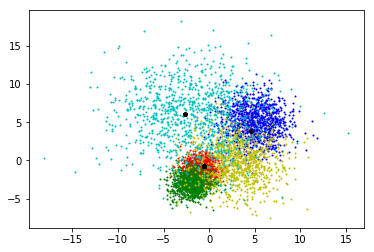

In [89]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

def update_plot(i, data, scat):
    scat.set_array(data[i])
    return scat,

num_clusters = 5
input_dim = 2
xCount = 1000
logits = tf.placeholder(tf.float32, shape=[5, xCount, input_dim]) #(n, t, d)
inputs = tf.reshape(logits, [-1, input_dim]) #(n*t, d)

with tf.variable_scope('scope1', reuse=tf.AUTO_REUSE):
    #(k, d)
    alfas = tf.get_variable('alfa',dtype=tf.float32, shape=[num_clusters]) #(k)
    alfas_pow = tf.square(alfas)+1e-10
    MUs = tf.get_variable("mu", shape=[num_clusters, input_dim],dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer(), trainable=False)
    weights = tf.matmul( 2*tf.matrix_diag(alfas_pow), MUs ) #(k, d)
    biases = -tf.multiply(alfas_pow, tf.reduce_sum(tf.square(MUs),1)) #(k)
    output = tf.matmul(inputs, tf.transpose(weights)) + biases #(n*t, k)
    PI = tf.nn.softmax(output) #(n*t, k)
    res = tf.matrix_diag(tf.reciprocal(tf.reduce_sum(PI, 0)+1e-10))

    tileInputs = tf.tile(inputs, [1, num_clusters])
    tileInputs2 = tf.reshape(tileInputs, [-1, num_clusters, input_dim])    # (n*t, k, d)

    offcenter = tileInputs2 - MUs # (n*t, k, d)
    # MUs = tf.assign(MUs, tf.matmul(tf.matrix_inverse(tf.matrix_diag(tf.reduce_sum(PI, 0))), tf.matmul(tf.transpose(PI), inputs)))
    MUs = tf.assign(MUs, tf.matmul(res, tf.matmul(tf.transpose(PI), inputs)))

    distances = tf.reduce_sum(tf.square(offcenter), -1)   # (n*t, k)
    vladLoss = tf.reduce_sum(tf.multiply(PI, distances))/(num_clusters)

    gStep = tf.Variable(tf.constant(0))
    learning_rate = tf.train.exponential_decay(float(0.1), gStep, 1000, 0.93, staircase=True)
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(vladLoss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# centers = [[-1,-2],[2,1],[3,3],
#            [1,1],[2,0],[3,2],
#            [-1,-1],[-2,0],[3,-2]]
# alf = [2,0,-1,2,4,9,2,3,6]
inp1 = np.random.normal(loc=[-2,-5], scale=0.5, size=(xCount, input_dim))
inp2 = np.random.normal(loc=[1,7], scale=6, size=(xCount, input_dim))
inp3 = np.random.normal(loc=[-2,-1], scale=1.1, size=(xCount, input_dim))
inp4 = np.random.normal(loc=[3,-5], scale=2.5, size=(xCount, input_dim))
inp5 = np.random.normal(loc=[-3,9], scale=4, size=(xCount, input_dim))

inpu = np.zeros((5,xCount,input_dim))
inpu[0,:] = inp1
inpu[1,:] = inp2
inpu[2,:] = inp3
inpu[3,:] = inp4
inpu[4,:] = inp5

batch1 = np.zeros((2,xCount,input_dim))
batch1[0,:] = inp1
batch1[1,:] = inp2
batch2 = np.zeros((2,xCount,input_dim))
batch2[0,:] = inp3
batch2[1,:] = inp4
batch3 = np.zeros((2,xCount,input_dim))
batch3[0,:] = inp1
batch3[1,:] = inp5
batch4 = np.zeros((2,xCount,input_dim))
batch4[0,:] = inp2
batch4[1,:] = inp3
batch5 = np.zeros((2,xCount,input_dim))
batch5[0,:] = inp4
batch5[1,:] = inp5

#print batch.shape
# print inp
for epoch in range(3000):
    _,vladLoss2,m,lr = sess.run([train_op, vladLoss, MUs,learning_rate], feed_dict={logits:inpu, gStep: epoch})
    # _,vladLoss2,m,lr = sess.run([train_op, vladLoss, MUs,learning_rate], feed_dict={logits:batch1, gStep: epoch})
    # _,vladLoss2,m,lr = sess.run([train_op, vladLoss, MUs,learning_rate], feed_dict={logits:batch2, gStep: epoch})
    # _,vladLoss2,m,lr = sess.run([train_op, vladLoss, MUs,learning_rate], feed_dict={logits:batch3, gStep: epoch})
    # _,vladLoss2,m,lr = sess.run([train_op, vladLoss, MUs,learning_rate], feed_dict={logits:batch4, gStep: epoch})
    # _,vladLoss2,m,lr = sess.run([train_op, vladLoss, MUs,learning_rate], feed_dict={logits:batch5, gStep: epoch})
    if(epoch%100==0):
        print lr, vladLoss2
        # print vladLoss2
        # print m
        # print lr
        # break


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(inp1[:,0],inp1[:,1],c = 'r',marker = 'o', s=1)
ax1.scatter(inp2[:,0],inp2[:,1],c = 'b',marker = 'o', s=1)
ax1.scatter(inp3[:,0],inp3[:,1],c = 'g',marker = 'o', s=1)
ax1.scatter(inp4[:,0],inp4[:,1],c = 'y',marker = 'o', s=1)
ax1.scatter(inp5[:,0],inp5[:,1],c = 'c',marker = 'o', s=1)

ax1.scatter(m[0][0],m[0][1],c = 'k',marker = 'p', s=22)
ax1.scatter(m[1][0],m[1][1],c = 'k',marker = 'p', s=22)
ax1.scatter(m[2][0],m[2][1],c = 'k',marker = 'p', s=22)
ax1.scatter(m[3][0],m[3][1],c = 'k',marker = 'p', s=22)
ax1.scatter(m[4][0],m[4][1],c = 'k',marker = 'p', s=22)
plt.show()
